In [14]:
#!pip install -q pyreadr seaborn
# !wget -O 48_-_breast_cancer_data.RData "https://zenodo.org/records/7657781/files/48_-_breast_cancer_data.RData?download=1"

import pyreadr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


raw_data = pyreadr.read_r('48_-_breast_cancer_data.RData')['out']
raw_data.to_csv('dataset')

df = raw_data.copy()

df = df.drop(index=1285)
df.head()

,der_ordinal_v1a,der_days_fu,der_deadbinary,der_dead30,der_mv,der_ICU,der_hosp,der_AKI_comp,der_MOF_comp,der_coinfection_any,...,der_txline,der_heme,der_metastatic,der_met_bone,der_met_liver,der_met_lung_v2,der_age_trunc,der_CV_event_v2,der_pulm_event,der_GI_event
0,0,30.0,No,No,No,No,No,No,No,No,...,First line,0,Missing/Unknown,NaN,NaN,NaN,58.0,No,Yes,No
1,0,180.0,No,No,No,No,No,No,No,NaN,...,Non-curative NOS,0,Yes,Yes,No,No,67.0,No,No,No
2,1,10.5,No,No,No,No,Yes,No,No,NaN,...,First line,0,No,No,No,No,42.0,No,No,No
3,1,180.0,No,No,No,No,Yes,No,No,No,...,Untreated in last 12 months,0,Yes,Yes,Yes,No,49.0,No,Yes,No
4,0,180.0,No,No,No,No,No,No,No,No,...,First line,0,No,No,No,No,47.0,No,No,No


## setup

In [15]:
df_reg = df[['der_age_trunc', 'der_cancer_status_v4', 'severity_of_covid_19_v2', 'der_deadbinary']].dropna()
df_reg['active_cancer'] = df_reg['der_cancer_status_v4'].map(lambda x: 'Active' in x)
df_reg['moderate_severe_covid'] = df_reg['severity_of_covid_19_v2'].map(lambda x: 'Active' in x)


median_age = df_reg['der_age_trunc'].median()
mean_age = df_reg['der_age_trunc'].mean()

# custom color palette
colors = ["#169489", "#1E5F94", '#EC6433', "#293237"]
palette = sns.color_palette(colors)

median_age, mean_age

(61.0, 61.2596011816839)

## utils

In [16]:
def jont_confidence_interval(df, grouby, start, stop, significance_level=0.05):
  """
  Get the ages (in integers) in which the one-sample-ttest is significant, at the
  given significance level.
  """
  interval = []
  for m in range(start, stop):
    mean_passes = True
    for c, g in df.groupby(grouby):
      if len(g) > 0:
        sample = g['der_age_trunc'].values.astype('float32')

        # one-sample-ttest
        res = stats.ttest_1samp(sample, m)

        if res.pvalue < significance_level:
          mean_passes = False
          break
    if mean_passes:
      interval.append(m)
  return interval

## Analysis 1:
- The one-sample t-test which was performed for each cancer status, cannot provide sufficient evidence to reject the null hypothesis at the hypothesized average age of 58 (highlighted by a red line) at a 5% significance level.
- In fact, 58 is the only age at which we fail to reject the null hypothesis: the population mean and hypothesized mean are the same.
- When testing the normality in age distribution, we fail to reject the null hypothesis at the 1% significance level (i.e. they appear normally distributed) when grouped by cancer status
- When testing the normality in age distribution for the population, we failed to reject the null hypothesis at the 5% significance level.

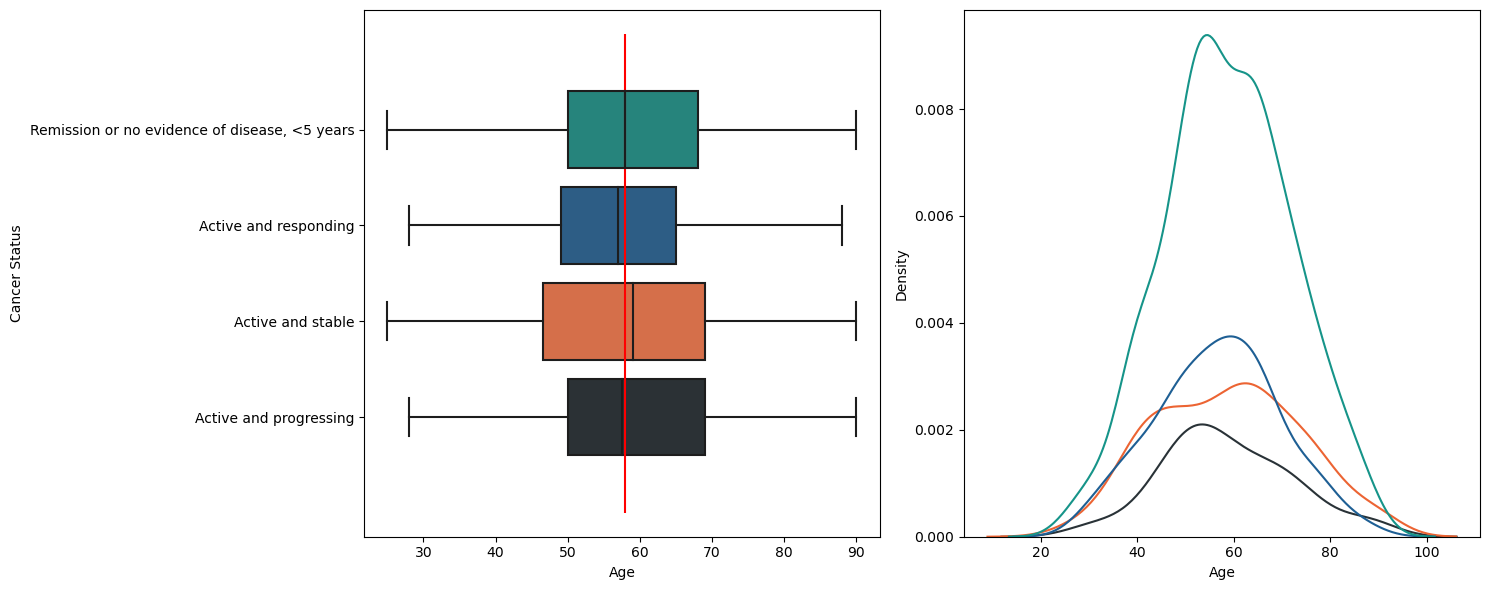

In [17]:
# set order of levels
hue_order = ['Active and progressing',  'Active and stable', 'Active and responding', 'Remission or no evidence of disease, <5 years'][::-1]

# Creating the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# First plot
sns.boxplot(data=df_reg, x="der_age_trunc", y="der_cancer_status_v4", ax=axes[0], palette=palette, order=hue_order)
axes[0].vlines(x = 58, ymin = -1, ymax = 4,
           colors = 'red',
           label = 'Confidence level at the 0.05 significance level')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Cancer Status')

# Second plot
sns.kdeplot(data=df_reg, x="der_age_trunc", hue='der_cancer_status_v4', ax=axes[1], palette=palette, hue_order=hue_order)
axes[1].set_xlabel('Age')

# Adjust the layout
plt.tight_layout()

#axes[0].legend(hue_order, loc='lower right')
axes[1].get_legend().remove()

# save
plt.savefig('dean1.png')

# Display the plot
plt.show()

In [18]:
df_sub = df_reg[df_reg['der_cancer_status_v4'] != 'Remission or no evidence of disease, >5 years']
df_sub = df_sub[df_sub['der_cancer_status_v4'] != 'Unknown']

# 95% confidence interval
jont_confidence_interval(df_sub, 'der_cancer_status_v4', 55, 65)

[58]

In [19]:
# 99% confidence interval
jont_confidence_interval(df_sub, 'der_cancer_status_v4', 55, 65, significance_level=0.01)

[58, 59]

In [20]:
# overal for age
stats.normaltest(df_reg['der_age_trunc'].values)

NormaltestResult(statistic=43.58320407318808, pvalue=3.435796901377786e-10)

In [21]:
# test normality at each level
for c, g in df_reg.groupby('der_cancer_status_v4'):
  if c not in  ['Unknown', 'Remission or no evidence of disease, >5 years']:
    sample = g['der_age_trunc'].values.astype('float32')
    norm_test = res = stats.normaltest(sample)
    print(c, '|', norm_test)

Active and progressing | NormaltestResult(statistic=1.2798658002306793, pvalue=0.5273278064909499)
Active and responding | NormaltestResult(statistic=1.4701817786821447, pvalue=0.47946187902019377)
Active and stable | NormaltestResult(statistic=6.936995810766319, pvalue=0.0311638065073874)
Remission or no evidence of disease, <5 years | NormaltestResult(statistic=4.706614415851944, pvalue=0.09505427754791879)


## Analysis 2:
- The average age of patients with Mild, Moderate, and Severe COVID statuses are 56.22, 64.28, and 59.03 respectively. These averages are much higher than the hypothesized average age of 58 (highlighted by a red line) for people with active cancer statuses.
- only the ages of patients with mild and moderate COVID status appear to be normally distributed (at the 5% significance level)


C:\Users\hamza\AppData\Local\Temp\ipykernel_30656\3461739468.py:15: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.kdeplot(data=df_reg, x="der_age_trunc", hue='severity_of_covid_19_v2',  ax=axes[1], hue_order=hue_order, palette=palette, multiple='stack')


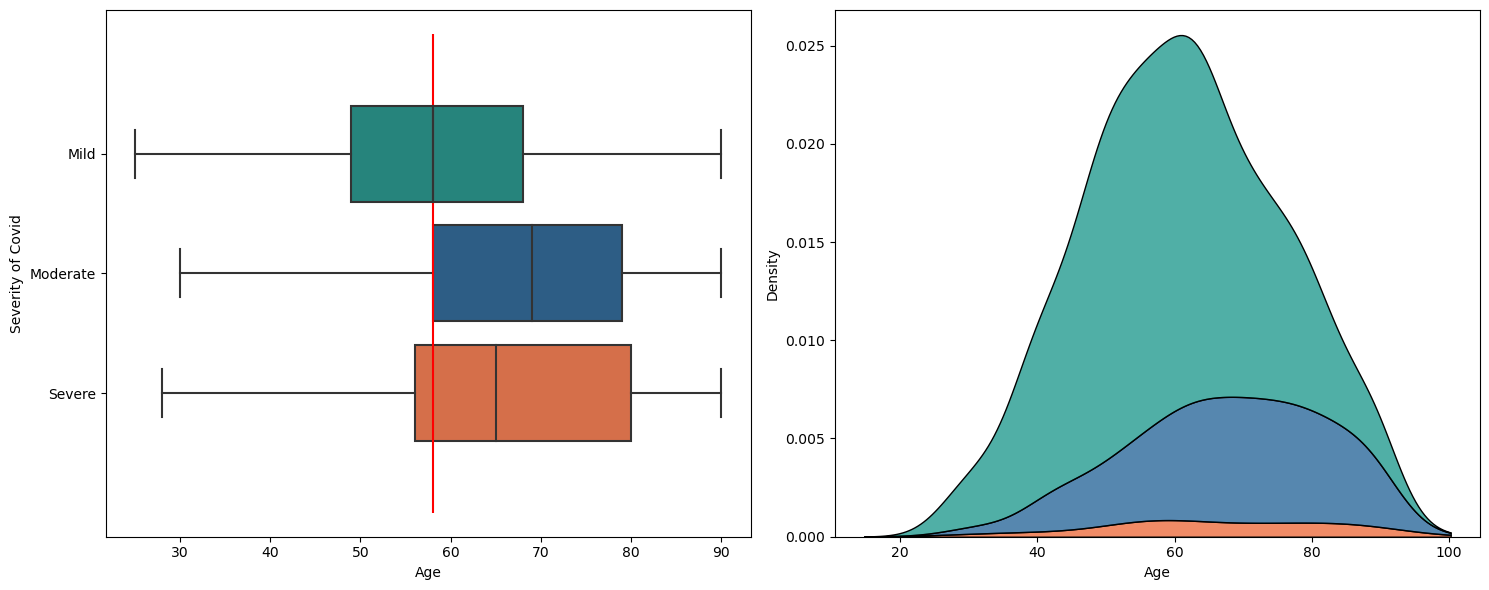

In [22]:
# Creating the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

hue_order = ['Mild', 'Moderate', 'Severe']

# First plot
sns.boxplot(data=df_reg, x="der_age_trunc", y="severity_of_covid_19_v2", ax=axes[0], order=hue_order, palette=palette)
axes[0].vlines(x = 58, ymin = -1, ymax = 3,
           colors = 'red',
           label = 'vline_multiple - full height')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Severity of Covid')

# Second plot
sns.kdeplot(data=df_reg, x="der_age_trunc", hue='severity_of_covid_19_v2',  ax=axes[1], hue_order=hue_order, palette=palette, multiple='stack')
axes[1].set_xlabel('Age')

# Adjust the layout
plt.tight_layout()

#axes[0].legend(hue_order, loc='lower right')
axes[1].get_legend().remove()

# save
plt.savefig('dean2.png')

# Display the plot
plt.show()

In [23]:
# test normality at each level
for c, g in df_reg.groupby('severity_of_covid_19_v2'):
    if c != 'Unknown':
        res = stats.normaltest(g['der_age_trunc'].values.astype('float32'))
        print(c, '|', res)

Mild | NormaltestResult(statistic=13.043820878273872, pvalue=0.0014708564347965228)
Moderate | NormaltestResult(statistic=16.449231664258775, pvalue=0.0002679752768872689)
Severe | NormaltestResult(statistic=1.9951040215318612, pvalue=0.3687811092694821)


In [ ]:
!pip install pandas -U

In [ ]:
df_sub

In [15]:
df_sub[['der_age_trunc', 'severity_of_covid_19_v2']].groupby('severity_of_covid_19_v2').mean()['der_age_trunc']

<ipython-input-15-e81577df7989>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sub[['der_age_trunc', 'severity_of_covid_19_v2']].groupby('severity_of_covid_19_v2').mean()['der_age_trunc']


severity_of_covid_19_v2
Mild        56.219396
Moderate    64.276786
Severe      59.034483
Name: der_age_trunc, dtype: float64

# test for outliers in age

In [30]:
quartiles = df['der_age_trunc'].quantile([0.25,0.5,0.75]).values
iqr = quartiles[-1] - quartiles[0]
quartiles, iqr

(array([51., 61., 72.]), 21.0)

In [31]:
ages = df['der_age_trunc'].values
outliers = [x for x in ages if ((x < (quartiles[0] - (1.5*iqr))) | (x > (quartiles[2] + (1.5*iqr))))]
print(f'There are {len(outliers)} outliers based on age')

There are 0 outliers based on age


der_age_trunc    Axes(0.125,0.11;0.775x0.77)
dtype: object

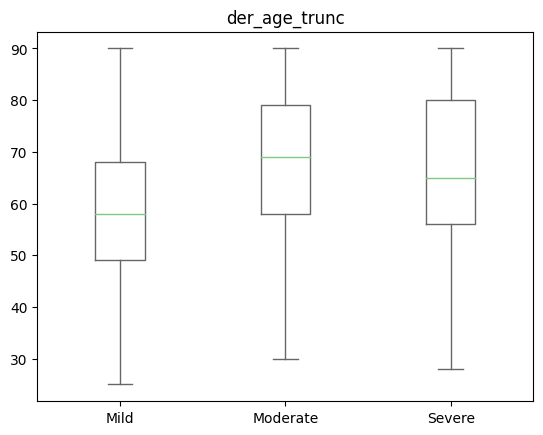

In [32]:
df_reg.plot(kind='box', column="der_age_trunc", by="severity_of_covid_19_v2", cmap='Accent_r')

der_age_trunc    Axes(0.125,0.11;0.775x0.77)
dtype: object

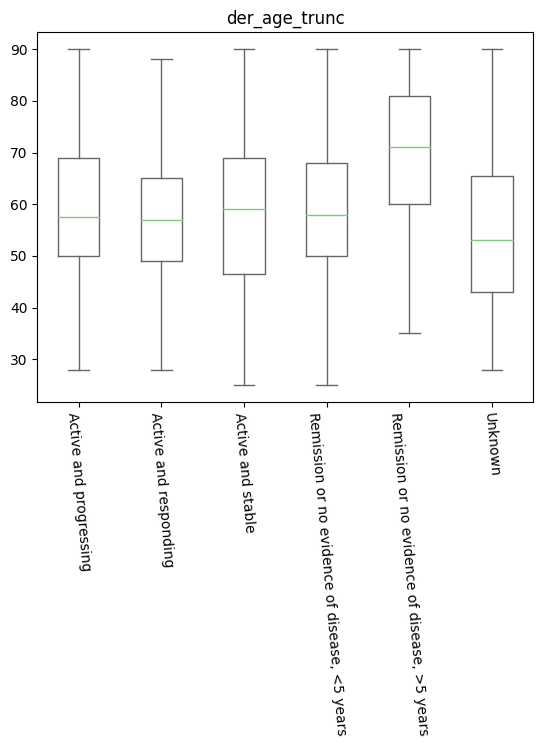

In [33]:
df_reg.plot(kind='box', column="der_age_trunc", by="der_cancer_status_v4", cmap='Accent_r', rot=-85, )
#plt.set_xticklabels(labels, rotation=90, ha='right')

## determine if there are any potential outliers across all cancer statuses

In [34]:
df_reg.der_cancer_status_v4.unique()

['Active and responding', 'Active and stable', 'Unknown', 'Remission or no evidence of disease, <5 years', 'Active and progressing', 'Remission or no evidence of disease, >5 years']
Categories (6, object): ['Active and progressing', 'Active and responding', 'Active and stable',
                         'Remission or no evidence of disease, <5 years', 'Remission or no evidence of disease, >5 years',
                         'Unknown']

Text(0, 0.5, 'Cancer Status')

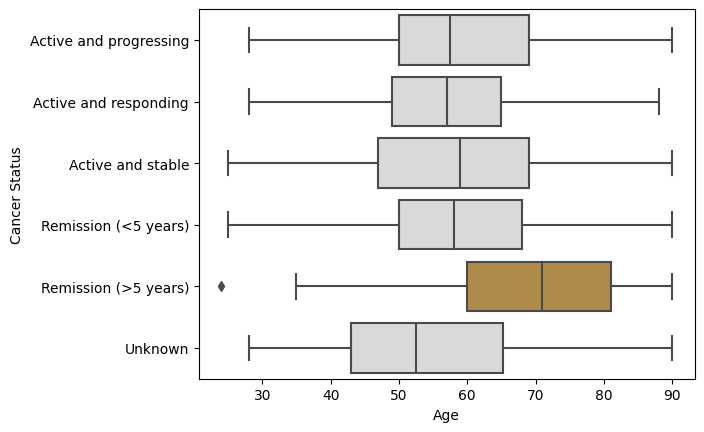

In [35]:
df_reg = raw_data[['der_age_trunc', 'der_cancer_status_v4']].dropna()
grey = (217, 217, 217)
rename  = {'Active and responding': 'Active and responding',
           'Active and stable': 'Active and stable',
           'Unknown': 'Unknown',
           'Remission or no evidence of disease, <5 years': 'Remission (<5 years)',
           'Active and progressing': 'Active and progressing',
           'Remission or no evidence of disease, >5 years': 'Remission (>5 years)'}
df_reg['der_cancer_status_v4'] = df_reg['der_cancer_status_v4'].map(lambda x: rename[x])
import seaborn as sns
colors = ["#D9D9D9", "#D9D9D9", "#D9D9D9", "#D9D9D9", "#BF9039"]

sns.boxplot(data=df_reg, x="der_age_trunc", y="der_cancer_status_v4", palette=sns.color_palette(colors))
plt.xlabel('Age')
plt.ylabel('Cancer Status')

In [36]:
df_reg['der_cancer_status_v4'].unique()

['Active and responding', 'Active and stable', 'Unknown', 'Remission (<5 years)', 'Active and progressing', 'Remission (>5 years)']
Categories (6, object): ['Active and progressing', 'Active and responding', 'Active and stable',
                         'Remission (<5 years)', 'Remission (>5 years)', 'Unknown']

In [37]:
df_rem = df_reg[df_reg['der_cancer_status_v4'] == 'Remission (>5 years)']

quartiles = df_rem['der_age_trunc'].quantile([0.25,0.5,0.75]).values
iqr = quartiles[-1] - quartiles[0]

ages = df_rem['der_age_trunc'].values
outlier_index = []
outliers = (ages < (quartiles[0] - (1.5*iqr))) + (ages > (quartiles[2] + (1.5*iqr)))

print(f'There are {sum(outliers)} outliers based on age')

There are 1 outliers based on age


In [38]:
outlier_index = df_rem[outliers].index
outlier_index

Int64Index([1285], dtype='int64')

In [39]:
raw_data.loc[outlier_index].iloc[0].to_dict() # ['der_smoking2': 'No', 'der_obesity': 'No', 'severity_of_covid_19_v2': 'Mild','der_region_v2': 'Northeast']

{'der_ordinal_v1a': 0,
 'der_days_fu': 90.0,
 'der_deadbinary': 'No',
 'der_dead30': 'No',
 'der_mv': 'No',
 'der_ICU': 'No',
 'der_hosp': 'No',
 'der_AKI_comp': 'No',
 'der_MOF_comp': 'No',
 'der_coinfection_any': 'No',
 'der_sepsis_comp': 'No',
 'der_bleeding_comp': 'No',
 'der_rem': 'No',
 'der_hcq': 'No',
 'der_steroids_c19': 'No',
 'der_other_tx_c19_v2': 'No',
 'der_o2_ever': 'No',
 'der_race_v2': 'Non-Hispanic White',
 'der_insurance': 'Private +/- other',
 'der_smoking2': 'Never',
 'der_obesity': 'No',
 'der_card': 'No',
 'der_pulm': 'No',
 'der_renal': 'No',
 'der_dm2': 'No',
 'der_ecogcat2': '0',
 'der_breast_biomarkers': 'HER2+',
 'der_cancer_status_v4': 'Remission or no evidence of disease, >5 years',
 'der_cancer_tx_timing_v2': '>3 months',
 'der_cancertr_none': 'Yes',
 'der_any_cyto': 'No',
 'der_any_targeted': 'No',
 'der_her2_3m': 'No',
 'der_cdk46i_3m': 'No',
 'der_other_3m': 'No',
 'der_any_endo': 'No',
 'der_any_immuno': 'No',
 'der_any_local': 'No',
 'der_any_other':